# Capstone 2 Modeling (hour)

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   Pre-processing and Training Data Development
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   **Modeling**
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [90]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tbats import BATS, TBATS
%matplotlib inline

In [91]:
# load the csv files in data/processed folder
df2 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df24.csv', index_col='Date')
df6 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2016.csv', index_col='Date')
df7 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2017.csv', index_col='Date')
dfts = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\dfts.csv', index_col='Date')
# change indexes to time series
df2.index = pd.to_datetime(df2.index)
df6.index = pd.to_datetime(df6.index)
df7.index = pd.to_datetime(df7.index)
dfts.index = pd.to_datetime(dfts.index)
# set the index frequency
df2.index.freq="D"
df6.index.freq="D"
df7.index.freq="D"

In [158]:
# dfts doesn't have 24 hours, so we will reindex it and fill in the missing hours with 0
dfts24 = dfts.reindex(pd.date_range('2016-01-04', periods=17472, freq='h'), fill_value=0)
# check for total number of hours
display(len(dfts24))
# check and see if there's NaN and date range are what we want
display(dfts24.isnull().any())
display(dfts24.head())
display(dfts24.tail())

17472

sales    False
dtype: bool

,sales
2016-01-04 00:00:00,0.0
2016-01-04 01:00:00,0.0
2016-01-04 02:00:00,0.0
2016-01-04 03:00:00,0.0
2016-01-04 04:00:00,0.0


,sales
2017-12-31 19:00:00,18.980000
2017-12-31 20:00:00,91.013462
2017-12-31 21:00:00,86.495385
2017-12-31 22:00:00,61.535769
2017-12-31 23:00:00,0.000000


In [93]:
# mkae a hourly time series dataframe with 2016 info
dfts2016 = dfts24.iloc[:8736]
dfts2016.index.freq="H" #set time series index frequency to hourly
dfts2016 #note we included 1/1 of 2017 to make it total of 364 days

,sales
2016-01-04 00:00:00,0.00
2016-01-04 01:00:00,0.00
2016-01-04 02:00:00,0.00
2016-01-04 03:00:00,0.00
2016-01-04 04:00:00,0.00
...,...
2017-01-01 19:00:00,85.69
2017-01-01 20:00:00,62.06
2017-01-01 21:00:00,117.45
2017-01-01 22:00:00,89.25


In [94]:
# 2017 will be the remaining and should be 8736 rows as well
dfts2017 = dfts24.iloc[8736:]
dfts2017.index.freq="H" #set time series index frequency to hourly
dfts2017

,sales
2017-01-02 00:00:00,0.000000
2017-01-02 01:00:00,0.000000
2017-01-02 02:00:00,0.000000
2017-01-02 03:00:00,0.000000
2017-01-02 04:00:00,0.000000
...,...
2017-12-31 19:00:00,18.980000
2017-12-31 20:00:00,91.013462
2017-12-31 21:00:00,86.495385
2017-12-31 22:00:00,61.535769


In [96]:
# make a baseline dataframe that consist of date rane 2018-01-01 (Mon) and onward of next 8736 hours
# with sales values that's average of 2016 and 2017

# make a dataframe with 2016 and 2017's info
bl_df = pd.concat([dfts2016.sales.reset_index(), dfts2017.sales.reset_index()], axis=1, ignore_index=True)
bl_df.columns=['2016', 'sales2016', '2017', 'sales2017']
# define an avg function to get the avg of 2 inputs, then we can use it to df.apply lambda and get the baseline
def avg(one, two):
    return (one + two)/2
# get the baseline values that's the average of 2016 and 2017
bl_df['baseline'] = bl_df.apply(lambda x: avg(x['sales2016'], x['sales2017']), axis=1)
#set index to date ranging from 2018-01-01 until 8736 hours later
bl_df.index = pd.date_range('2018-01-01', periods=8736, freq='H')
#remove unnecessary columns; just keep the baseline column
bl_df = bl_df.baseline
# save the dataframe to csv file for easier access
bl_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\hourly_baseline.csv',
                      index=True)
bl_df

2018-01-01 00:00:00      0.000000
2018-01-01 01:00:00      0.000000
2018-01-01 02:00:00      0.000000
2018-01-01 03:00:00      0.000000
2018-01-01 04:00:00      0.000000
                          ...    
2018-12-30 19:00:00     52.335000
2018-12-30 20:00:00     76.536731
2018-12-30 21:00:00    101.972692
2018-12-30 22:00:00     75.392885
2018-12-30 23:00:00      0.000000
Freq: H, Name: baseline, Length: 8736, dtype: float64

# Correlograms

Autocorrelogram & Partial Autocorrelogram is useful that to estimate each models parameters.

We will use 9/1/2017 until end of 2017 as testing data, while forecasting until end of 2018-12-29 to compare with the baseline.

In [97]:
#train_test_split and forecast dates
train_start,train_end = '2016-01-04 00','2017-09-30 23'
test_start,test_end = '2017-10-01 00','2017-12-31 23'
forecast_start, forecast_end = '2018-01-01','2018-12-29 23'
train = dfts24['sales'][train_start:train_end].dropna()
test = dfts24['sales'][test_start:test_end].dropna()
baseline = bl_df

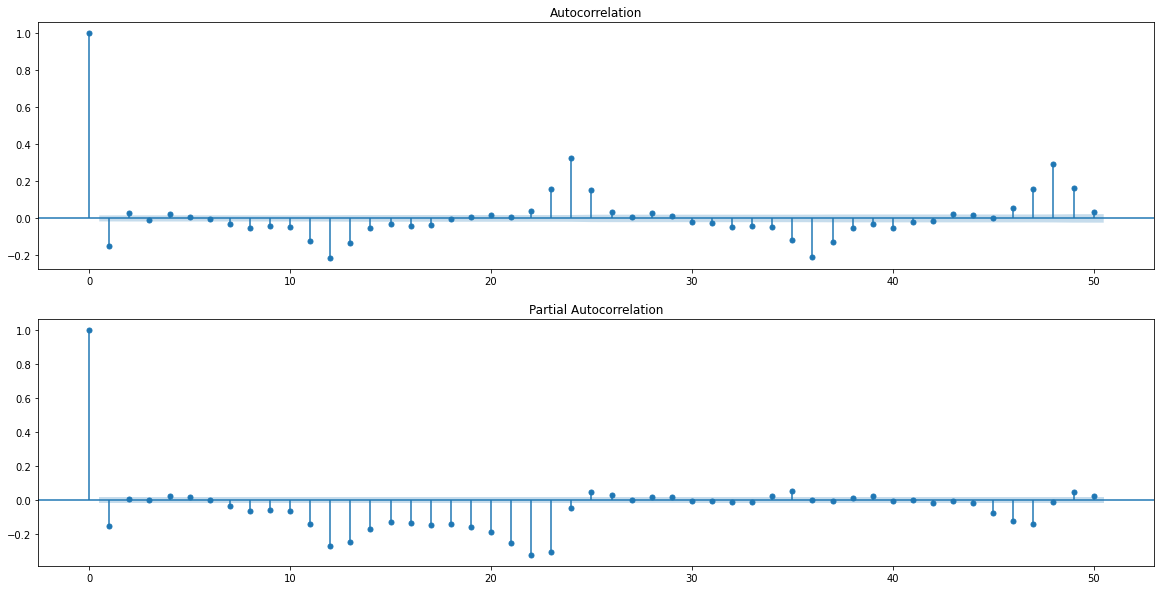

In [98]:
#we use train.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train.diff().dropna(), lags=50, ax=ax[1])
plt.show()

From Autocorrelation, we can see that there's a recurring pattern every 24 periods, indicating a daily pattern exists, and from previous modeling (day) we already know that there's also a strong weekly pattern, which makes it 24*7=168.

In [99]:
#need to change working directory to figure so we can save the figures in its folder
path="C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\figures"
os.chdir(path)

# TBATS
From modeling the daily sales data, TBATS was able to capture both weekly and yearly seasonality, let's give it a try and see if it's able to capture yearly seasonality as well.

In [45]:
# Fit the model, seasonal_periods=(24, 168, 8736) for daily weekly then yearly seasonality
tbats = TBATS(seasonal_periods=(24, 168, 8736)).fit(train)

In [47]:
# forecasts
pred = tbats.forecast(steps=(len(test)))
fore = tbats.forecast(steps=(len(test)+8736))

In [49]:
#create a dataframe to record and save the scores as csv
TBATS_df = pd.DataFrame({
    'model':'TBATS-hourly',
    'MSE':mean_squared_error(test,pred),
    'MAE':mean_absolute_error(test,pred),
    'AIC':tbats.aic,
    'ForeMSE':mean_squared_error(baseline,fore[(len(test)):]),
    'ForeMAE':mean_absolute_error(baseline,fore[(len(test)):]),
})
TBATS_score.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly_score.csv',
                index=False)
TBATS_score

,model,MSE,MAE,AIC,ForeMSE,ForeMAE
0,TBATS-hourly,973.556926,21.355974,233391.760387,492.115389,16.227456


In [ ]:
# create a df to store the pred/forecast
TBATS_pred = pd.DataFrame({
    'pred':pred,
    'fore':fore,
})
TBATS_pred.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATShourly_pred.csv',
                index=False)

# auto_arima with exog features: DoW, Hour of Day, month, and 2 fourier terms

In [86]:
# since hourly data has much more columns than daily data
# we will test it with 91 days first to see
exog = pd.concat([dfts2016, dfts2017])
# 2 fourier terms
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 364)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 364)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 364)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 364)
#month one hot encoding
exog['month'] = exog.index.month
month_dummies = pd.get_dummies(exog['month'])
month_dummies.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
exog = pd.concat([exog, month_dummies], axis=1).drop(['month'],axis=1)
#     dayofweek one hot encoding
exog['DoW'] = exog.index.weekday
week_dummies = pd.get_dummies(exog['DoW'])
week_dummies.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
exog = pd.concat([exog, week_dummies], axis=1).drop(['DoW'],axis=1)
#     hour of day one hot encoding
exog['HoD'] = exog.index.hour
hour_dummies = pd.get_dummies(exog['HoD'])
hour_dummies.columns = [str(i) for i in range(24)]
exog = pd.concat([exog, hour_dummies], axis=1).drop(['HoD'],axis=1)
exog = exog.drop(columns=['sales'])

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

KeyboardInterrupt: 

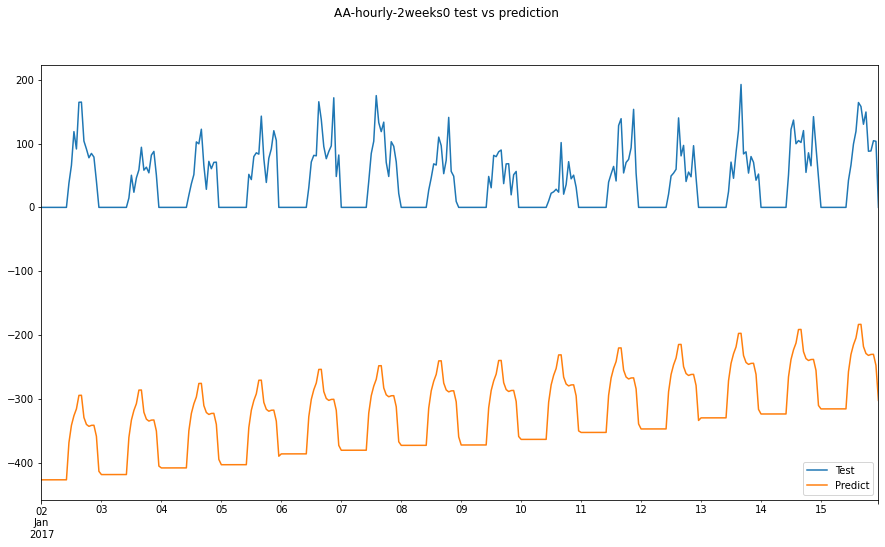

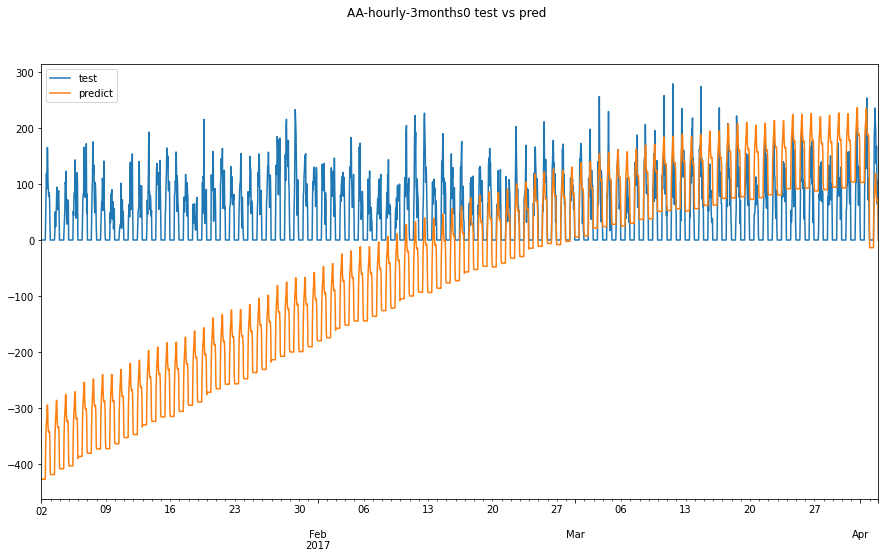

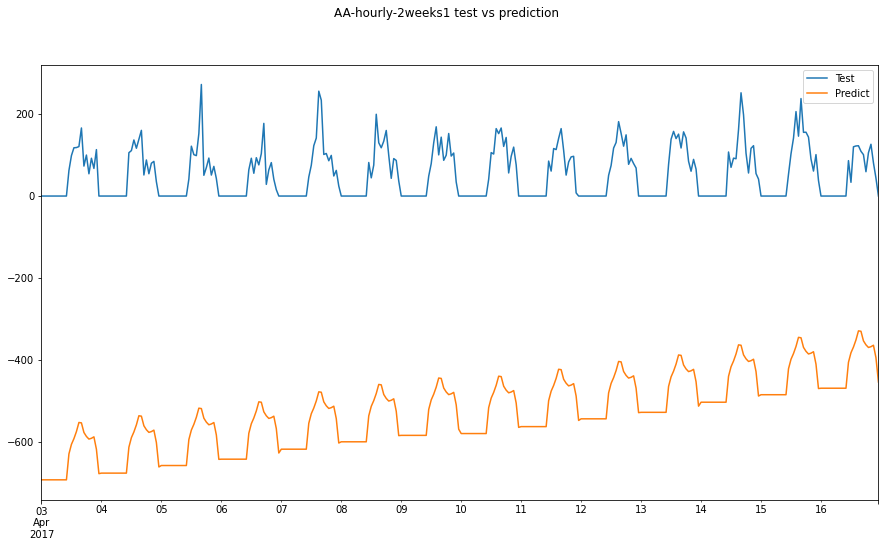

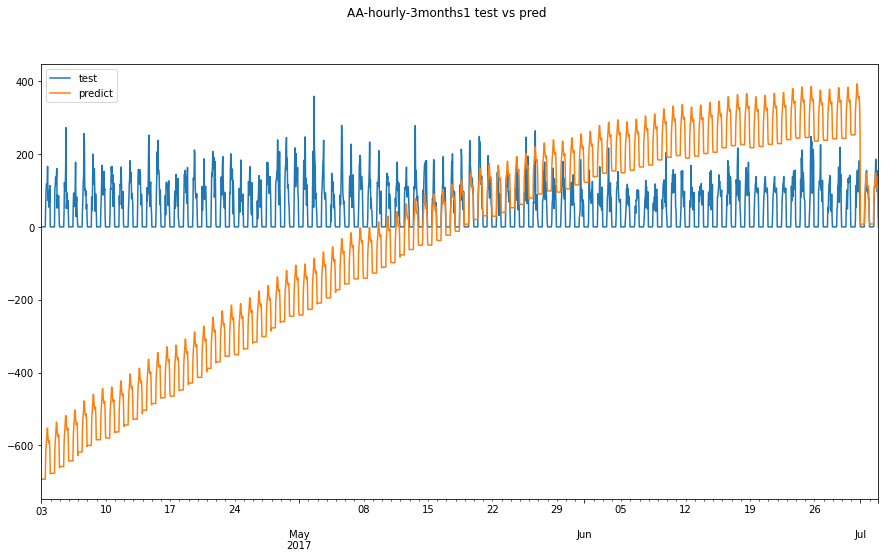

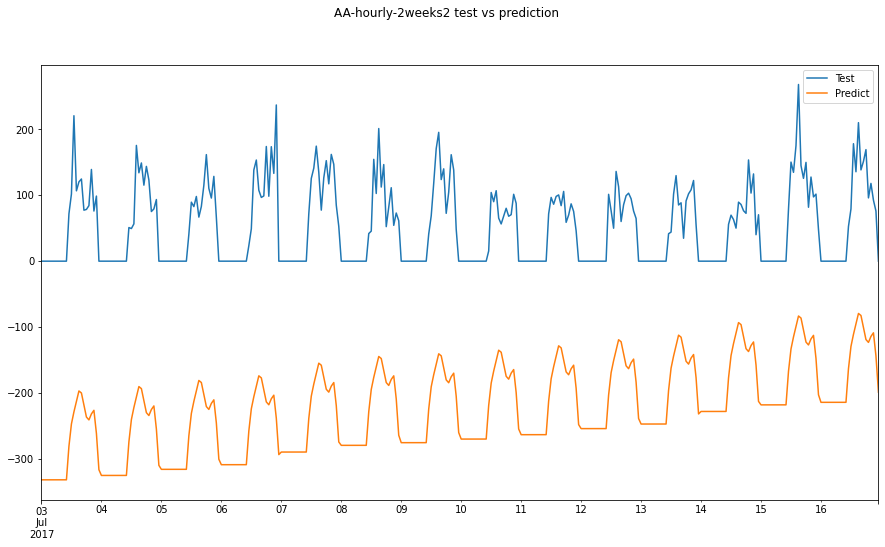

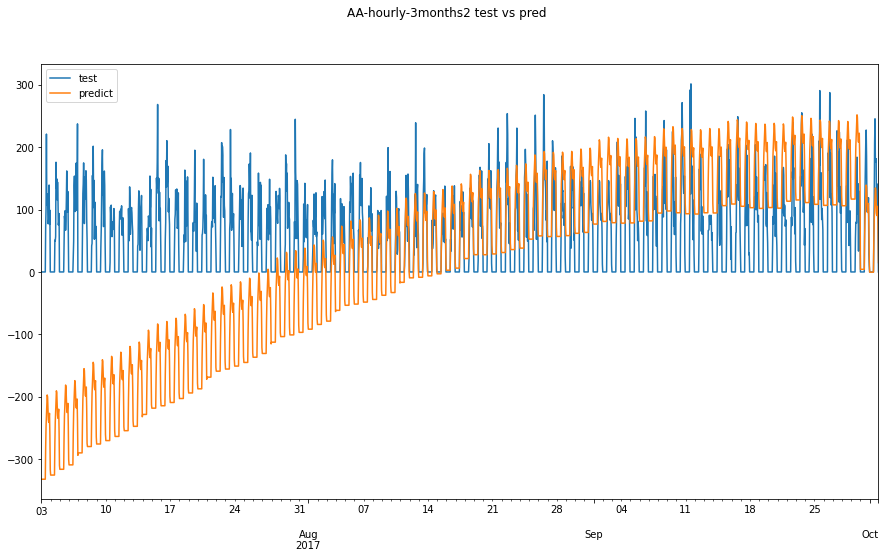

In [87]:
# create empty lists to store values
pred_list = []
i_list = []
MSE_list = []
MAE_list = []
# let's iterate and save the datas then combine them
for i in range(4): #4 periods of 91 days
    #set the train & test data
    train = dfts2016.iloc[(i*2184):((i+1)*2184)]
    test = dfts2017.iloc[(i*2184):((i+1)*2184)]
    #set the exog
    exog_to_train = exog.iloc[(i*2184):((i+1)*2184)]
    exog_to_test = exog.iloc[((i)*2184):((i+4)*2184)]
    # run the auto_arima
    AA_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=24)
    # forecast 1 year later so 8736
    forecast = AA_model.predict(n_periods=(len(exog_to_test)), exogenous=exog_to_test)
    # but we only need the same 91 days, so the last 2184 rows; skip the first 3*2184 rows
    pred = forecast[(3*2184):]
    # append the values to the empty lists
    i_list.append(i)
    MSE_list.append(mean_squared_error(test,pred))
    MAE_list.append(mean_absolute_error(test,pred))
    pred_list.append(pred)
    #get the plot of test vs pred first's 2 weeks
    pd.DataFrame({'test':test.sales[:(24*7*2)],'pred':pred[:(24*7*2)]}).plot(figsize=(15,8))
    plt.suptitle('AA-hourly-2weeks{} test vs prediction'.format(str(i)))
    plt.legend(["Test", "Predict"])
    plt.savefig('AA-hourly-2weeks{}_test_pred.png'.format(str(i)))
    #view the 2017 forecast
    pd.DataFrame({'test':test.sales, 'forecast':pred}).plot(figsize=(15,8))
    plt.suptitle('AA-hourly-3months{} test vs pred'.format(str(i)))
    plt.legend(["test", "predict"])
    plt.savefig('AA-hourly-3months{}_test_pred.png'.format(str(i)))

It looks like 2 fourier term doesn't work too well, resulting in too many negative numbers.

# AA with Month, DoW, HoD as exog
Using regular dummies will take too much memory, we will redo the dummies by allocating the normalized value of mentioned features. By its mean, e.g. if March has best mean for its month, it'll be 1, and other months will be its mean divide by March's mean.

# Month, HoD, DoW, and 2 fourier terms using 2016 as training data

In [149]:
exog = pd.concat([dfts2016, dfts2017])
#setting the normalized values of given month/HoD/DoW based on the max of its mean
exog['month'] = exog.index.month
exog['month'].replace([i for i in range(1,13)], [monthly2016[i]/monthly2016.max() for i in range(1,13)], inplace=True)
exog['HoD'] = exog.index.hour
exog['HoD'].replace([i for i in range(24)], [hourly2016[i]/hourly2016.max() for i in range(24)], inplace=True)
exog['DoW'] = exog.index.weekday
exog['DoW'].replace([i for i in range(7)], [dow2016[i]/dow2016.max() for i in range(7)], inplace=True)
# 2 fourier terms
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 364)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 364)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 364)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 364)
exog = exog.drop(columns=['sales'])
display(exog.head(3))
display(exog.tail(3))

,month,HoD,DoW,sin365,cos365,sin365_2,cos365_2
2016-01-04 00:00:00,0.773727,0.0,0.802414,0.068991,0.997617,0.137654,0.99048
2016-01-04 01:00:00,0.773727,0.0,0.802414,0.068991,0.997617,0.137654,0.99048
2016-01-04 02:00:00,0.773727,0.0,0.802414,0.068991,0.997617,0.137654,0.99048


,month,HoD,DoW,sin365,cos365,sin365_2,cos365_2
2017-12-31 21:00:00,0.815552,0.722349,0.991255,0.017261,0.999851,0.034516,0.999404
2017-12-31 22:00:00,0.815552,0.531965,0.991255,0.017261,0.999851,0.034516,0.999404
2017-12-31 23:00:00,0.815552,0.106475,0.991255,0.017261,0.999851,0.034516,0.999404


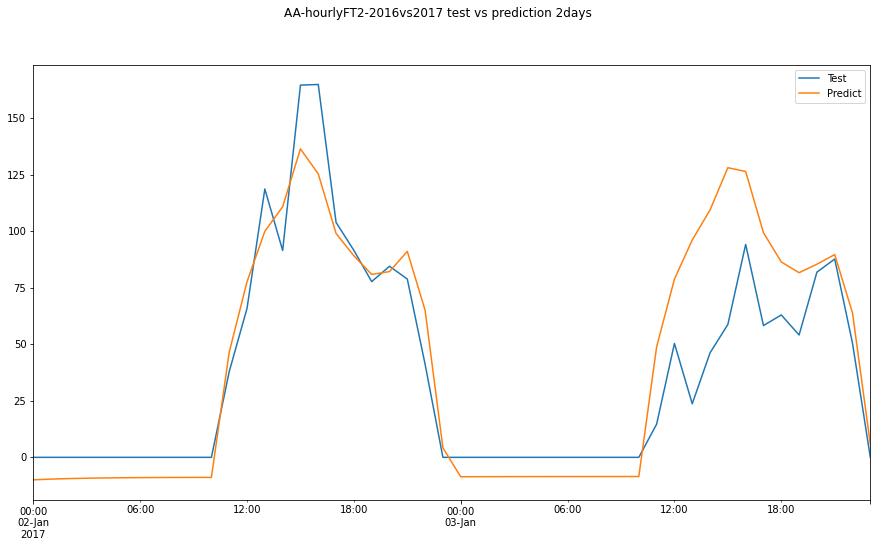

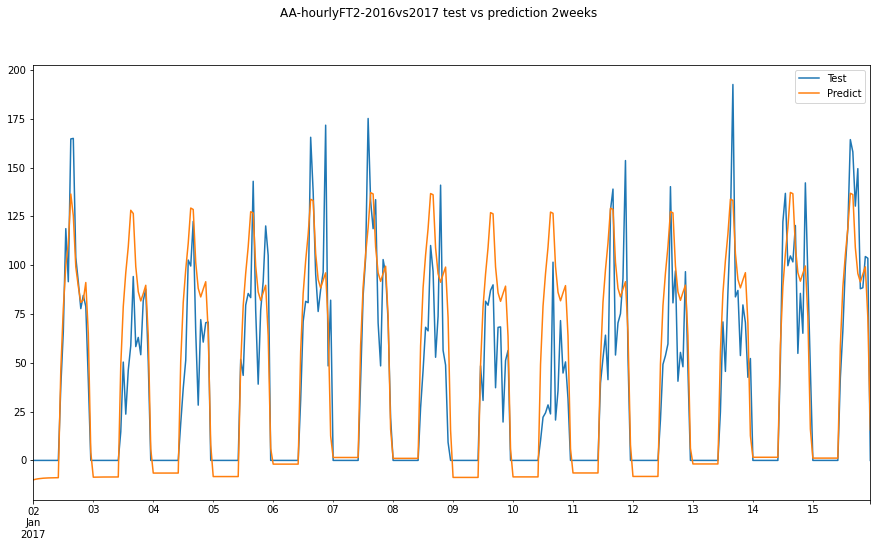

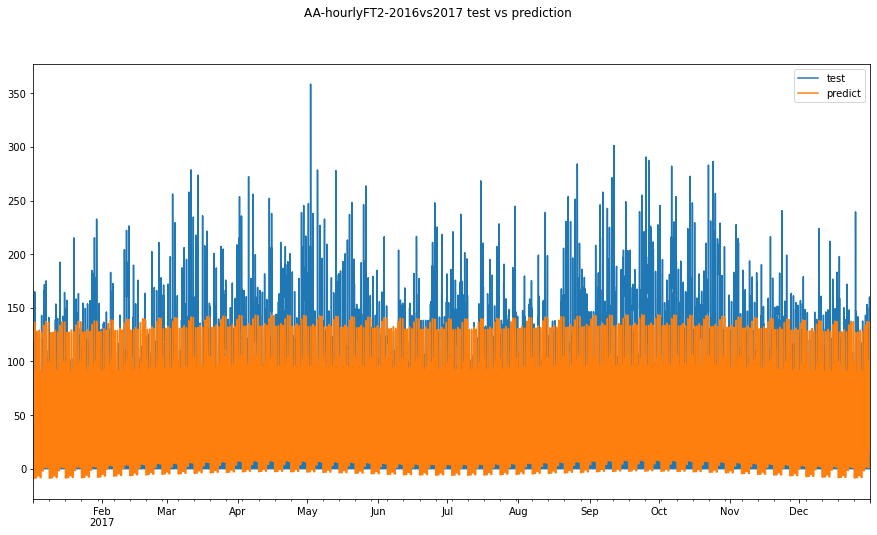

In [154]:
#set the train & test data
train = dfts2016.sales
test = dfts2017.sales
#set the exog which are the same since we always start with Monday at 00 hour
exog_to_train = exog.iloc[:(364*24)]
exog_to_test = exog.iloc[(364*24):] 
# run the auto_arima
model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=24)
# forecast
pred = model.predict(n_periods=(len(test)), exogenous=exog_to_test)
#get the plot of test vs pred first's 48 hours
pd.DataFrame({'test':test[:(24*2)],'pred':pred[:(24*2)]}).plot(figsize=(15,8))
plt.suptitle('AA-hourlyFT2-2016vs2017 test vs prediction 2days')
plt.legend(["Test", "Predict"])
plt.savefig('AA-hourlyFT2-2016vs2017 test vs prediction 2days.png')
#get the plot of test vs pred first's 2 weeks
pd.DataFrame({'test':test[:(24*7*2)],'pred':pred[:(24*7*2)]}).plot(figsize=(15,8))
plt.suptitle('AA-hourlyFT2-2016vs2017 test vs prediction 2weeks')
plt.legend(["Test", "Predict"])
plt.savefig('AA-hourlyFT2-2016vs2017 test vs prediction 2weeks.png')
#view the 2017 forecast
pd.DataFrame({'test':test, 'pred':pred}).plot(figsize=(15,8))
plt.suptitle('AA-hourlyFT2-2016vs2017 test vs prediction')
plt.legend(["test", "predict"])
plt.savefig('AA-hourlyFT2-2016vs2017 test vs prediction.png')
# make a dataframe with predidction and metric scores and save as csv
AA_modelFT2_df = pd.DataFrame({
    'pred':pred,
    'MSE':mean_squared_error(test, pred),
    'MAE':mean_absolute_error(test,pred)},)
AA_modelFT2_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\hourly_FT2.csv', index=False)

In [156]:
# see the metric
AA_modelFT2_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\hourly_FT2.csv')
AA_modelFT2_df

,pred,MSE,MAE
0,-9.949630,810.525794,17.696391
1,-9.627823,810.525794,17.696391
2,-9.397860,810.525794,17.696391
3,-9.233529,810.525794,17.696391
4,-9.116098,810.525794,17.696391
...,...,...,...
8731,91.365312,810.525794,17.696391
8732,95.404399,810.525794,17.696391
8733,99.142652,810.525794,17.696391
8734,73.320831,810.525794,17.696391


Once again, the daily periodicity is well captured, but not so much with weekly/yearly.

# Exog with ranked order for month, DoW. But HoD with normalized.

In [63]:
# let's take a look at each month's hourly mean
monthly2016.sort_values()

1     42.630027
12    44.934483
3     46.049949
7     48.185520
8     48.530766
6     48.950708
11    48.953594
10    52.317755
2     53.455925
9     54.229417
5     54.545161
4     55.097000
Name: sales, dtype: float64

In [78]:
# since each year should have 3 to 4 seasons, we will break monthly into 3 sales ratings for exog feature
display(monthly2016.quantile(0.67))
display(monthly2016.quantile(0.33))
monthly2016.sort_values()

52.738878085904766

48.40302515022137

1     42.630027
12    44.934483
3     46.049949
7     48.185520
8     48.530766
6     48.950708
11    48.953594
10    52.317755
2     53.455925
9     54.229417
5     54.545161
4     55.097000
Name: sales, dtype: float64

In [76]:
# let's make a quantile based hourly sales by month
monthly2016q = monthly2016.copy()
monthly2016q[1, 12, 3, 7] = 1 #worst sales
monthly2016q[8, 6, 11, 10] = 2 #in between
monthly2016q[2, 9, 5, 4] = 3 #best sales
monthly2016q.sort_values()

1     1.0
3     1.0
7     1.0
12    1.0
6     2.0
8     2.0
10    2.0
11    2.0
2     3.0
4     3.0
5     3.0
9     3.0
Name: sales, dtype: float64

In [71]:
# let's skip hour of day, the periodicity was shown greatly
# so let's take a look at day of week
dow2016.sort_values()

0    45.189601
1    45.466166
3    45.686576
2    47.644199
4    52.619622
6    55.824588
5    56.317072
Name: sales, dtype: float64

In [74]:
# it's obvious that friday, saturday and sunday has best sales. Especially saturday and sunday. So we should break it down
# from top to bottom, sat/sun > fri > wed > rest. so we have 4 quantiles
dow2016q = dow2016.copy()
dow2016q[0,1,3] = 1 #worst sales
dow2016q[2] = 2
dow2016q[4] = 3
dow2016q[6,5] = 4 #best sales
dow2016q.sort_values()

0    1.0
1    1.0
3    1.0
2    2.0
4    3.0
5    4.0
6    4.0
Name: sales, dtype: float64

In [117]:
# redo the exog
exog = pd.concat([dfts2016, dfts2017])
# set the month exog
exog['month'] = exog.index.month
exog['month'].replace([3,7,12], 1, inplace=True)
exog['month'].replace([2,4,5,9], 3, inplace=True)
exog['month'].replace([6,8,10,11], 2, inplace=True)
# set the DoW exog
exog['DoW'] = exog.index.weekday
exog['DoW'].replace([0,3], 1, inplace=True) #1 is already 1
exog['DoW'].replace(4, 3, inplace=True) # 2 is already 2, so let's change 4 to 3
exog['DoW'].replace([5,6], 4, inplace=True)
# set the HoD exog
exog['HoD'] = exog.index.hour
exog['HoD'].replace([i for i in range(24)], [hourly2016[i]/hourly2016.max() for i in range(24)], inplace=True)
# drop the sales columns
exog=exog.drop(columns=['sales'])
exog

,month,DoW,HoD
2016-01-04 00:00:00,1,1,0.000000
2016-01-04 01:00:00,1,1,0.000000
2016-01-04 02:00:00,1,1,0.000000
2016-01-04 03:00:00,1,1,0.000000
2016-01-04 04:00:00,1,1,0.000000
...,...,...,...
2017-12-31 19:00:00,1,4,0.665007
2017-12-31 20:00:00,1,4,0.694787
2017-12-31 21:00:00,1,4,0.722349
2017-12-31 22:00:00,1,4,0.531965


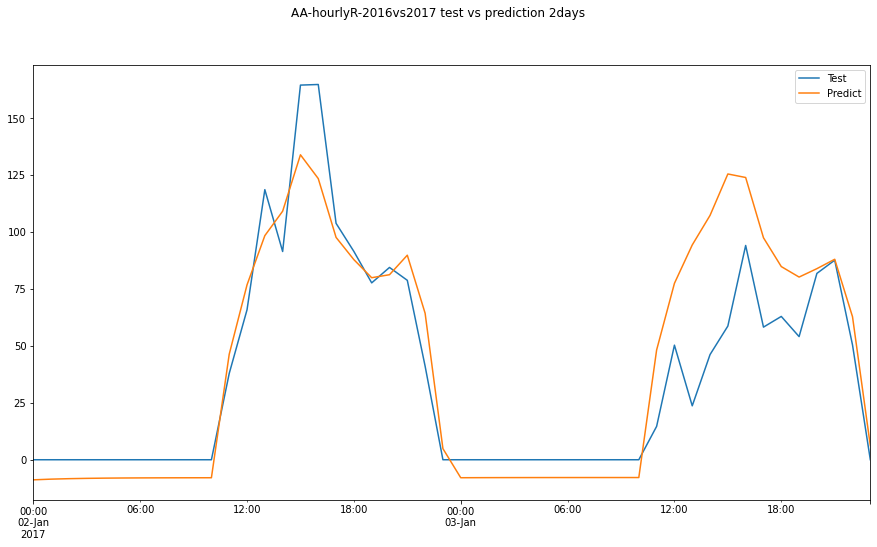

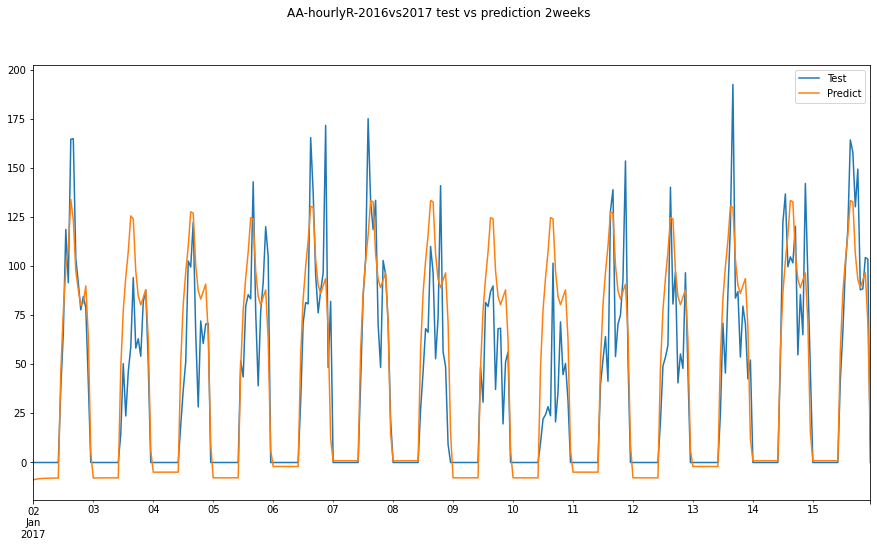

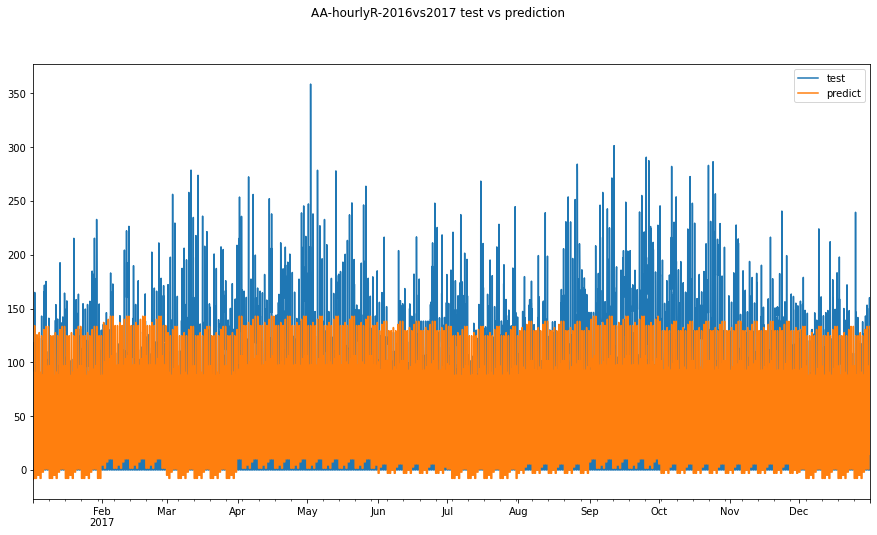

In [118]:
#set the train & test data
train = dfts2016
test = dfts2017
#set the exog which are the same since we always start with Monday at 00 hour
exog_to_train = exog.iloc[:(364*24)]
exog_to_test = exog.iloc[(364*24):] 
# run the auto_arima
AA_modelR = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=24)
# forecast
predR = AA_modelR.predict(n_periods=(len(test)), exogenous=exog_to_test)
#get the plot of test vs pred first's 48 hours
pd.DataFrame({'test':test.sales[:(24*2)],'pred':predR[:(24*2)]}).plot(figsize=(15,8))
plt.suptitle('AA-hourlyR-2016vs2017 test vs prediction 2days')
plt.legend(["Test", "Predict"])
plt.savefig('AA-hourlyR-2016vs2017 test vs prediction 2days.png')
#get the plot of test vs pred first's 2 weeks
pd.DataFrame({'test':test.sales[:(24*7*2)],'pred':predR[:(24*7*2)]}).plot(figsize=(15,8))
plt.suptitle('AA-hourlyR-2016vs2017 test vs prediction 2weeks')
plt.legend(["Test", "Predict"])
plt.savefig('AA-hourlyR-2016vs2017 test vs prediction 2weeks.png')
#view the 2017 forecast
pd.DataFrame({'test':test.sales, 'pred':predR}).plot(figsize=(15,8))
plt.suptitle('AA-hourlyR-2016vs2017 test vs prediction')
plt.legend(["test", "predict"])
plt.savefig('AA-hourlyR-2016vs2017 test vs prediction.png')

Only daily periodicity was well demostrated, there may seem to have yearly seasonality, but the values doesn't make much difference.